## Forward Particle Tracking, Structured Grid, Transient Flow

Application of a MODFLOW 6 particle-tracking (PRT)
model and a MODPATH 7 (MP7) model to solve example
problem 3 from the MODPATH 7 documentation.

This example modifies the system in examples 1 and
2 with transient flow. There are 3 stress periods:

| Stress period | Type         | Time steps | Length (days) | Multiplier |
|:--------------|:-------------|:-----------|:--------------|:-----------|
| 1             | steady-state | 1          | 100000        | 1          |
| 2             | transient    | 10         | 36500         | 1.5        |
| 3             | steady-state | 1          | 100000        | 1          |

Particles are released in groups of 25 from the top
left corner of the grid. Releases occur in groups of
25 every 20 days (for 200 days), starting 90,000 days
into the simulation, for 1000 particles in total.

At the beginning of the 2nd stress period, 2 wells
begin to pump at a constant rate, one in the first
layer and another in the third. The wells continue
to pump until the simulation ends.


### Initial setup

Import dependencies, define the example name and workspace,
and read settings from environment variables.

In [1]:
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from flopy.mf6 import MFSimulation
from flopy.plot.styles import styles
from matplotlib.lines import Line2D
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-prt-mp7-p03"
# shorten model names so they fit in 16-char limit
gwf_name = sim_name.replace("ex-prt-", "") + "-gwf"
prt_name = sim_name.replace("ex-prt-", "") + "-prt"
mp7_name = sim_name.replace("ex-prt-", "") + "-mp7"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
sim_ws = workspace / sim_name
gwf_ws = sim_ws / "gwf"
prt_ws = sim_ws / "prt"
mp7_ws = sim_ws / "mp7"
gwf_ws.mkdir(exist_ok=True, parents=True)
prt_ws.mkdir(exist_ok=True, parents=True)
mp7_ws.mkdir(exist_ok=True, parents=True)

# Define output file names
headfile = f"{gwf_name}.hds"
budgetfile = f"{gwf_name}.cbb"
budgetfile_prt = f"{prt_name}.cbb"
trackfile_prt = f"{prt_name}.trk"
trackhdrfile_prt = f"{prt_name}.trk.hdr"
trackcsvfile_prt = f"{prt_name}.trk.csv"
pathlinefile_mp7 = f"{mp7_name}.mppth"
endpointfile_mp7 = f"{mp7_name}.mpend"
timeseriesfile_mp7 = f"{mp7_name}.timeseries"

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "feet"
time_units = "days"

# Model parameters
nper = 3  # Number of periods
nlay = 3  # Number of layers
nrow = 21  # Number of rows
ncol = 20  # Number of columns
delr = 500.0  # Column width ($ft$)
delc = 500.0  # Row width ($ft$)
top = 350.0  # Top of the model ($ft$)
botm_str = "220.0, 200.0, 0.0"  # Layer bottom elevations ($ft$)
kh_str = "50.0, 0.01, 200.0"  # Horizontal hydraulic conductivity ($ft/d$)
kv_str = "10.0, 0.01, 20.0"  # Vertical hydraulic conductivity ($ft/d$)
rchv = 0.005  # Recharge rate ($ft/d$)
riv_h = 320.0  # River stage ($ft$)
riv_z = 317.0  # River bottom ($ft$)
riv_c = 1.0e5  # River conductance ($ft^2/d$)
porosity = 0.1  # Soil porosity (unitless)

# Time discretization
perioddata = [
    # perlen, nstp, tsmult
    (100000, 1, 1),
    (36500, 10, 1.5),
    (100000, 1, 1),
]

# Parse bottom elevation and horiz/vert hydraulic cond.
botm = [float(value) for value in botm_str.split(",")]
kh = [float(value) for value in kh_str.split(",")]
kv = [float(value) for value in kv_str.split(",")]

# Layer types
laytyp = [1, 0, 0]

# Define well data.
# Negative discharge indicates pumping, positive injection.
wells = [
    # layer, row, col, discharge
    (0, 10, 9, -75000),
    (2, 12, 4, -100000),
]

# Define the drain location.
drain = (0, 14, (9, 20))

# Define the river data.
riv_iface = 6
riv_iflowface = -1
rd = []
for i in range(nrow):
    rd.append([(0, i, ncol - 1), riv_h, riv_c, riv_z, riv_iface, riv_iflowface])

# Configure locations for particle tracking to terminate. We
# have three explicitly defined termination zones:
#
# - 2: the well in layer 1, at row 11, column 10
# - 3: the well in layer 3, at row 13, column 5
# - 4: the drain in layer 1, running through row 15 from column 10-20
# - 5: the river in layer 1, running through column 20
#
# MODFLOW 6 reserves zone number 1 to indicate that particles
# may move freely within the zone.

In [3]:
def get_izone():
    izone = []

    # zone 1 is the default (non-terminating)
    def ones():
        return np.ones((nrow, ncol), dtype=np.int32)

    # layer 1
    l1 = ones()
    l1[wells[0][1:3]] = 2  # well
    l1[drain[1], drain[2][0] : drain[2][1]] = 4  # drain
    l1[:, ncol - 1] = 5  # river
    izone.append(l1)

    # layer 2
    izone.append(1)

    # layer 3
    l3 = ones()
    l3[wells[1][1:3]] = 3  # well
    izone.append(l3)

    return izone


izone = get_izone()



Define particles to track. Particles are released from the top of a
2x2 square of cells in the upper left of the midel grid's top layer.
MODPATH 7 uses a reference time value of 0.9 to start the release at
90,000 days into the simulation.

In [4]:

ref_time = 0.9
ref_time_days = int(ref_time * 10**5)
rel_minl = rel_maxl = 0
rel_minr = 2
rel_maxr = 3
rel_minc = 2
rel_maxc = 3
celldata = flopy.modpath.CellDataType(
    drape=0,
    rowcelldivisions=5,
    columncelldivisions=5,
    layercelldivisions=1,
)
lrcregions = [[rel_minl, rel_minr, rel_minc, rel_maxl, rel_maxr, rel_maxc]]
lrcpd = flopy.modpath.LRCParticleData(
    subdivisiondata=[celldata],
    lrcregions=[lrcregions],
)
pg = flopy.modpath.ParticleGroupLRCTemplate(
    particlegroupname="PG1",
    particledata=lrcpd,
    filename=f"{mp7_name}.pg1.sloc",
    releasedata=(10, 0, 20),
)
pgs = [pg]
defaultiface = {"RECHARGE": 6, "ET": 6}

# Define well and river cell numbers, used to extract and plot model results later.

# Get well and river cell numbers
nodes = {"well1": [], "well2": [], "drain": [], "river": []}
for idx, (k, i, j, _) in enumerate(wells):
    nodes[f"well{idx + 1}"].append(ncol * (nrow * k + i) + j)
for j in drain[2]:
    k, i = drain[:2]
    nodes["drain"].append([ncol * (nrow * k + i) + j])
for rivspec in rd:
    k, i, j = rivspec[0]
    node = ncol * (nrow * k + i) + j
    nodes["river"].append(node)

### Model setup

Define functions to build models, write input files, and run the simulation.

In [5]:


def build_gwf_model():
    # simulation
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name, exe_name="mf6", version="mf6", sim_ws=gwf_ws
    )

    # temporal discretization
    tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
        sim,
        pname="tdis",
        time_units=time_units,
        nper=len(perioddata),
        perioddata=perioddata,
    )

    # groundwater flow (gwf) model
    model_nam_file = f"{gwf_name}.nam"
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=gwf_name, model_nam_file=model_nam_file, save_flows=True
    )

    # iterative model solver (ims) package
    ims = flopy.mf6.modflow.mfims.ModflowIms(
        sim,
        pname="ims",
        complexity="SIMPLE",
    )
    sim.register_solution_package(ims, [gwf.name])

    # grid discretization
    dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        gwf,
        pname="dis",
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        length_units="FEET",
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )

    # initial conditions
    ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=320)

    # node property flow
    npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
        gwf,
        pname="npf",
        icelltype=laytyp,
        k=kh,
        k33=kv,
        save_flows=True,
        save_specific_discharge=True,
        save_saturation=True,
    )

    # recharge
    rch = flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(gwf, recharge=rchv)

    # storage
    sto = flopy.mf6.modflow.mfgwfsto.ModflowGwfsto(
        gwf,
        save_flows=True,
        iconvert=1,
        ss=0.0001,
        sy=0.1,
        steady_state={0: True, 2: True},
        transient={1: True},
    )

    # wells
    def no_flow(w):
        return w[0], w[1], w[2], 0

    nf_wells = [no_flow(w) for w in wells]
    wel = flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
        gwf,
        maxbound=2,
        stress_period_data={0: nf_wells, 1: wells, 2: wells},
    )

    # river
    flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(
        gwf, auxiliary=["iface", "iflowface"], stress_period_data={0: rd}
    )

    # drain (set auxiliary IFACE var to 6 for top of cell)
    drn_iface = 6
    drn_iflowface = -1
    dd = [
        [drain[0], drain[1], i + drain[2][0], 322.5, 100000.0, drn_iface, drn_iflowface]
        for i in range(drain[2][1] - drain[2][0])
    ]
    drn = flopy.mf6.modflow.mfgwfdrn.ModflowGwfdrn(
        gwf, auxiliary=["iface", "iflowface"], maxbound=11, stress_period_data={0: dd}
    )

    # output control
    oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
        gwf,
        pname="oc",
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        head_filerecord=[headfile],
        budget_filerecord=[budgetfile],
    )

    return sim


def build_prt_model():
    # simulation
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name, exe_name="mf6", version="mf6", sim_ws=prt_ws
    )

    # temporal discretization
    tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
        sim,
        pname="tdis",
        time_units=time_units,
        nper=len(perioddata),
        perioddata=perioddata,
    )

    # Instantiate the MODFLOW 6 prt model
    prt = flopy.mf6.ModflowPrt(
        sim, modelname=prt_name, model_nam_file=f"{prt_name}.nam"
    )

    # Instantiate the MODFLOW 6 prt discretization package
    flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        prt,
        pname="dis",
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        length_units="FEET",
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )

    # Instantiate the MODFLOW 6 prt model input package.
    flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity, izone=izone)

    # Convert MODPATH 7 particle configuration to format expected by PRP.
    release_points = list(lrcpd.to_prp(prt.modelgrid, localz=True))

    # Specify custom release times starting 90,000 days into
    # the simulation, repeating every 20 days, for 200 days.
    release_times = list(range(ref_time_days, 90200, 20))

    # Instantiate the MODFLOW 6 PRT particle release point (PRP) package.
    flopy.mf6.ModflowPrtprp(
        prt,
        pname="prp1",
        filename=f"{prt_name}_1.prp",
        nreleasepts=len(release_points),
        packagedata=release_points,
        nreleasetimes=len(release_times),
        releasetimes=[(t,) for t in release_times],
        # local z coordinates specified, compute global release
        # coord from cell top if saturated or water table if not
        local_z=True,
        exit_solve_tolerance=1e-5,
        extend_tracking=True,
    )

    # Instantiate the MODFLOW 6 prt output control package
    track_times = list(range(90000, 150001, 2000))
    flopy.mf6.ModflowPrtoc(
        prt,
        pname="oc",
        budget_filerecord=[budgetfile_prt],
        trackcsv_filerecord=[trackcsvfile_prt],
        track_release=True,
        track_terminate=True,
        track_usertime=True,
        ntracktimes=len(track_times),
        tracktimes=[(t,) for t in track_times],
        saverecord=[("BUDGET", "ALL")],
    )

    # Instantiate the MODFLOW 6 prt flow model interface
    flopy.mf6.ModflowPrtfmi(
        prt,
        packagedata=[
            ("GWFHEAD", pl.Path(f"../{gwf_ws.name}/{headfile}")),
            ("GWFBUDGET", pl.Path(f"../{gwf_ws.name}/{budgetfile}")),
        ],
    )

    # Create an explicit model solution (EMS) for the MODFLOW 6 prt model
    ems = flopy.mf6.ModflowEms(
        sim,
        pname="ems",
        filename=f"{prt_name}.ems",
    )
    sim.register_solution_package(ems, [prt.name])

    return sim


def build_mp7_model(gwf):
    print("Building MODPATH 7 model...")

    mp = flopy.modpath.Modpath7(
        modelname=mp7_name,
        flowmodel=gwf,
        exe_name="mp7",
        model_ws=mp7_ws,
    )
    mpbas = flopy.modpath.Modpath7Bas(mp, porosity=porosity, defaultiface=defaultiface)
    mpsim = flopy.modpath.Modpath7Sim(
        mp,
        pathlinefilename=pathlinefile_mp7,
        endpointfilename=endpointfile_mp7,
        timeseriesfilename=timeseriesfile_mp7,
        simulationtype="combined",
        trackingdirection="forward",
        weaksinkoption="pass_through",
        weaksourceoption="pass_through",
        budgetoutputoption="summary",
        referencetime=[0, 0, 0.9],
        timepointdata=[30, 2000.0],
        zonedataoption="on",
        zones=izone,
        particlegroups=pgs,
    )

    return mp


def build_models():
    gwfsim = build_gwf_model()
    prtsim = build_prt_model()
    mp7sim = build_mp7_model(gwfsim.get_model(gwf_name))
    return gwfsim, prtsim, mp7sim


def write_models(*sims, silent=False):
    for sim in sims:
        if isinstance(sim, MFSimulation):
            sim.write_simulation(silent=silent)
        else:
            sim.write_input()


@timed
def run_models(*sims, silent=False):
    for sim in sims:
        if isinstance(sim, MFSimulation):
            success, buff = sim.run_simulation(silent=silent, report=True)
        else:
            success, buff = sim.run_model(silent=silent, report=True)
        assert success, pformat(buff)


def get_mf6_pathlines(path):
    # load mf6 pathlines
    pl = pd.read_csv(path)

    # index temporarily by composite key fields
    pl.set_index(["iprp", "irpt", "trelease"], drop=False, inplace=True)

    # determine which particles ended up in which capture zone
    pl["destzone"] = pl[pl.istatus > 1].izone
    pl["dest"] = pl.apply(
        lambda row: (
            "well"
            if (row.destzone == 2 or row.destzone == 3)
            else (
                "drain"
                if row.destzone == 4
                else "river"
                if row.destzone == 5
                else pd.NA
            )
        ),
        axis=1,
    )

    # reset index
    pl.reset_index(drop=True, inplace=True)

    # convert indices to 0-based
    for n in ["imdl", "iprp", "irpt", "ilay", "icell"]:
        pl[n] -= 1

    return pl


def get_mp7_timeseries(path, gwf_model):
    file = flopy.utils.TimeseriesFile(path)
    ts = pd.DataFrame(
        file.get_destination_timeseries_data(list(range(gwf_model.modelgrid.nnodes)))
    )

    # adjust time column since mp7 reports time w.r.t. reference time
    ts["time"] = ts["time"] + ref_time_days

    return ts


def get_mp7_endpoints(path, gwf_model):
    file = flopy.utils.EndpointFile(path)
    ep = pd.DataFrame(
        file.get_destination_endpoint_data(list(range(gwf_model.modelgrid.nnodes)))
    )

    # adjust time column since mp7 reports time w.r.t. reference time
    ep["time"] = ep["time"] + ref_time_days

    return ep


def get_mp7_pathlines(timeseriesfile_path, endpointfile_path, gwf):
    timeseries = get_mp7_timeseries(timeseriesfile_path, gwf)
    endpoints = get_mp7_endpoints(endpointfile_path, gwf)
    return pd.concat([timeseries, endpoints]).reset_index(drop=False)

### Plotting results

Define functions to plot model results.

In [6]:
# Pathline and starting point colors by destination
colordest = {"well": "red", "drain": "green", "river": "blue"}


def plot_pathlines(ax, gwf, data, **kwargs):
    ax.set_aspect("equal")
    pl = flopy.plot.PlotMapView(model=gwf, ax=ax)
    pl.plot_grid(lw=0.5, alpha=0.5)
    pl.plot_bc("WEL", plotAll=True)
    pl.plot_bc("RIV", plotAll=True)
    pl.plot_bc("DRN", plotAll=True, color="green")

    for dest in ["well", "drain", "river"]:
        label = None
        if "colordest" in kwargs:
            color = kwargs["colordest"][dest]
            label = "Captured by " + dest
        elif "color" in kwargs:
            color = kwargs["color"]
        else:
            color = "grey"
        d = data[data.dest == dest]
        pl.plot_pathline(
            d, layer="all", colors=[color], label=label, linewidth=0.5, alpha=0.5
        )


def plot_points(fig, ax, gwf, data, colorbar=True, **kwargs):
    ax.set_aspect("equal")
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mm.plot_grid(lw=0.5, alpha=0.5)
    if "colordest" in kwargs:
        pts = []
        for dest in ["well", "river", "drain"]:
            color = kwargs["colordest"][dest]
            label = "Captured by " + dest
            pdata = data[data.dest == dest]
            pts.append(
                ax.scatter(pdata["x"], pdata["y"], s=3, color=color, label=label)
            )
        return pts
    else:
        pts = ax.scatter(
            data["x"],
            data["y"],
            s=3,
            c=data["t"] if "t" in data.dtypes.keys() else data["time"],
        )
        if colorbar:
            cax = fig.add_axes([0.2, 0.19, 0.6, 0.01])
            cb = plt.colorbar(pts, cax=cax, orientation="horizontal", shrink=0.25)
            cb.set_label("Travel time (days)")


def plot_head(gwf, head):
    with styles.USGSPlot():
        fig, ax = plt.subplots(figsize=(7, 7))
        fig.tight_layout()
        ax.set_aspect("equal")
        ilay = 2
        cint = 0.25
        hmin = head[ilay, 0, :].min()
        hmax = head[ilay, 0, :].max()
        styles.heading(ax=ax, heading=f"Head, layer {ilay + 1!s}, time=0")
        mm = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
        mm.plot_grid(lw=0.5)
        mm.plot_bc("WEL", plotAll=True)
        mm.plot_bc("RIV", plotAll=True)
        mm.plot_bc("DRN", plotAll=True, color="green")

        pc = mm.plot_array(head[ilay, :, :], edgecolor="black", alpha=0.25)
        cb = plt.colorbar(pc, shrink=0.25, pad=0.1)
        cb.ax.set_xlabel(r"Head ($ft$)")

        levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
        cs = mm.contour_array(head[ilay, :, :], colors="white", levels=levels)
        plt.clabel(cs, fmt="%.1f", colors="white", fontsize=11)

        ax.legend(
            handles=[
                mpl.patches.Patch(color="red", label="Well"),
                mpl.patches.Patch(color="teal", label="River"),
                mpl.patches.Patch(color="green", label="Drain"),
            ],
            loc="upper left",
        )

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-head")


def plot_pathpoints(gwf, mf6pl, mp7pl=None, title=None):
    with styles.USGSPlot():
        fig, ax = plt.subplots(ncols=1 if mp7pl is None else 2, nrows=1, figsize=(7, 7))
        if title is not None:
            styles.heading(ax if mp7pl is None else ax[0], heading=title)

        plot_points(fig, ax if mp7pl is None else ax[0], gwf, mf6pl)
        if mp7pl is not None:
            plot_points(fig, ax[1], gwf, mp7pl, colorbar=False)

        if mp7pl is not None:
            ax[0].set_xlabel("MODFLOW 6 PRT")
            ax[1].set_xlabel("MODPATH 7")

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-paths-layer.png")


def plot_pathpoints_3d(gwf, mf6pl, title=None):
    import pyvista as pv
    from flopy.export.vtk import Vtk

    pv.set_plot_theme("document")
    axes = pv.Axes(show_actor=False, actor_scale=2.0, line_width=5)
    vert_exag = 10
    vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
    vtk.add_model(gwf)
    vtk.add_pathline_points(mf6pl)
    gwf_mesh, prt_mesh = vtk.to_pyvista()
    drn_mesh = pv.Box(
        bounds=[
            4500,
            10000,
            3000,
            3500,
            220 * vert_exag,
            gwf.output.head().get_data()[(0, 0, ncol - 1)] * vert_exag,
        ]
    )
    riv_mesh = pv.Box(
        bounds=[
            gwf.modelgrid.extent[1] - delc,
            gwf.modelgrid.extent[1],
            gwf.modelgrid.extent[2],
            gwf.modelgrid.extent[3],
            220 * vert_exag,
            gwf.output.head().get_data()[(0, 0, ncol - 1)] * vert_exag,
        ]
    )
    wel_mesh = pv.Box(bounds=(4500, 5000, 5000, 5500, 220 * vert_exag, top * vert_exag))
    wel2_mesh = pv.Box(bounds=(2000, 2500, 4000, 4500, 0, 200 * vert_exag))
    bed_mesh = pv.Box(
        bounds=[
            gwf.modelgrid.extent[0],
            gwf.modelgrid.extent[1],
            gwf.modelgrid.extent[2],
            gwf.modelgrid.extent[3],
            200 * vert_exag,
            220 * vert_exag,
        ]
    )
    gwf_mesh.rotate_z(110, point=axes.origin, inplace=True)
    gwf_mesh.rotate_y(-10, point=axes.origin, inplace=True)
    gwf_mesh.rotate_x(10, point=axes.origin, inplace=True)
    prt_mesh.rotate_z(110, point=axes.origin, inplace=True)
    prt_mesh.rotate_y(-10, point=axes.origin, inplace=True)
    prt_mesh.rotate_x(10, point=axes.origin, inplace=True)
    drn_mesh.rotate_z(110, point=axes.origin, inplace=True)
    drn_mesh.rotate_y(-10, point=axes.origin, inplace=True)
    drn_mesh.rotate_x(10, point=axes.origin, inplace=True)
    riv_mesh.rotate_z(110, point=axes.origin, inplace=True)
    riv_mesh.rotate_y(-10, point=axes.origin, inplace=True)
    riv_mesh.rotate_x(10, point=axes.origin, inplace=True)
    wel_mesh.rotate_z(110, point=axes.origin, inplace=True)
    wel_mesh.rotate_y(-10, point=axes.origin, inplace=True)
    wel_mesh.rotate_x(10, point=axes.origin, inplace=True)
    wel2_mesh.rotate_z(110, point=axes.origin, inplace=True)
    wel2_mesh.rotate_y(-10, point=axes.origin, inplace=True)
    wel2_mesh.rotate_x(10, point=axes.origin, inplace=True)
    bed_mesh.rotate_z(110, point=axes.origin, inplace=True)
    bed_mesh.rotate_y(-10, point=axes.origin, inplace=True)
    bed_mesh.rotate_x(10, point=axes.origin, inplace=True)

    def _plot(screenshot=False):
        p = pv.Plotter(
            window_size=[500, 500],
            off_screen=screenshot,
            notebook=False if screenshot else None,
        )
        p.enable_anti_aliasing()
        if title is not None:
            p.add_title(title, font_size=5)
        p.add_mesh(gwf_mesh, opacity=0.025, style="wireframe")
        p.add_mesh(
            prt_mesh,
            scalars="destzone",
            cmap=["red", "red", "green", "blue"],
            point_size=4,
            line_width=3,
            render_points_as_spheres=True,
            render_lines_as_tubes=True,
            smooth_shading=True,
        )
        p.add_mesh(drn_mesh, color="green", opacity=0.2)
        p.add_mesh(riv_mesh, color="teal", opacity=0.2)
        p.add_mesh(wel_mesh, color="red", opacity=0.3)
        p.add_mesh(wel2_mesh, color="red", opacity=0.2)
        p.add_mesh(bed_mesh, color="tan", opacity=0.1)
        p.remove_scalar_bar()
        p.add_legend(
            labels=[
                ("Well (layer 3)", "red"),
                ("Drain", "green"),
                ("River", "blue"),
            ],
            bcolor="white",
            face="r",
            size=(0.15, 0.15),
        )

        p.camera.zoom(2)
        p.show()
        if screenshot:
            p.screenshot(figs_path / f"{sim_name}-paths-3d.png")

    if plot_show:
        _plot()
    if plot_save:
        _plot(screenshot=True)


def plot_all_pathlines(gwf, mf6pl, title=None):
    with styles.USGSPlot():
        fig, ax = plt.subplots(figsize=(7, 7))
        if title is not None:
            styles.heading(ax, heading=title)

        plot_pathlines(ax, gwf, mf6pl, colordest=colordest)

        ax.legend(
            handles=[
                Line2D([0], [0], color="red", lw=1, label="Well"),
                Line2D([0], [0], color="blue", lw=1, label="River"),
                Line2D([0], [0], color="green", lw=1, label="Drain"),
            ],
        )

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-paths.png")


def plot_endpoints(
    gwf, mf6pts, mp7pts=None, title=None, fig_name=None, color="destination"
):
    with styles.USGSPlot():
        fig, ax = plt.subplots(
            ncols=1 if mp7pts is None else 2, nrows=1, figsize=(7, 7)
        )
        if title is not None:
            styles.heading(ax if mp7pts is None else ax[0], heading=title)

        kwargs = {}
        if color == "destination":
            kwargs["colordest"] = colordest

        pts = plot_points(fig, ax if mp7pts is None else ax[0], gwf, mf6pts, **kwargs)
        if mp7pts is not None:
            plot_points(fig, ax[1], gwf, mf6pts, **kwargs)

        if mp7pts is not None:
            ax[0].set_xlabel("MODFLOW 6 PRT")
            ax[1].set_xlabel("MODPATH 7")

        if color == "destination":
            (ax if mp7pts is None else ax[0]).legend(
                handles=[
                    Line2D(
                        [0],
                        [0],
                        color="red",
                        marker="o",
                        markerfacecolor="red",
                        markersize=5,
                        lw=0,
                        label="Well",
                    ),
                    Line2D(
                        [0],
                        [0],
                        color="blue",
                        marker="o",
                        markerfacecolor="blue",
                        markersize=5,
                        lw=0,
                        label="River",
                    ),
                    Line2D(
                        [0],
                        [0],
                        color="green",
                        marker="o",
                        markerfacecolor="green",
                        markersize=5,
                        lw=0,
                        label="Drain",
                    ),
                ],
            )
        else:
            cax = fig.add_axes([0.2, 0.18, 0.6, 0.01])
            cb = plt.colorbar(pts, cax=cax, orientation="horizontal", shrink=0.25)
            cb.set_label("Travel time")

        if plot_show:
            plt.show()
        if plot_save and fig_name is not None:
            fig.savefig(figs_path / f"{fig_name}.png")


def plot_all(gwfsim):
    # load results
    gwf = gwfsim.get_model(gwf_name)
    head = flopy.utils.HeadFile(gwf_ws / (gwf_name + ".hds")).get_data()
    mf6pathlines = get_mf6_pathlines(prt_ws / trackcsvfile_prt)
    mp7pathlines = get_mp7_pathlines(
        mp7_ws / timeseriesfile_mp7, mp7_ws / endpointfile_mp7, gwf
    )

    # plot the results
    plot_head(gwf, head=head)
    plot_pathpoints(gwf, mf6pathlines, title="2000-day points, colored by travel time")
    plot_pathpoints_3d(
        gwf, mf6pathlines, title="Pathlines, 2000-day points,\ncolored by destination"
    )
    plot_endpoints(
        gwf,
        mf6pathlines[(mf6pathlines.ireason == 0) | (mf6pathlines.ireason == 3)],
        title="Release and termination points, colored by destination",
        fig_name=f"{sim_name}-rel-term",
        color="destination",
    )

### Running the example

Define a function to run the example scenarios and plot results.

In [7]:
def scenario(silent=False):
    gwfsim, prtsim, mp7sim = build_models()
    if write:
        write_models(gwfsim, prtsim, mp7sim, silent=silent)
    if run:
        run_models(gwfsim, prtsim, mp7sim, silent=silent)
    if plot:
        plot_all(gwfsim)

Run the MODPATH 7 example problem 3 scenario.

Building MODPATH 7 model...


run_models took 904.46 ms


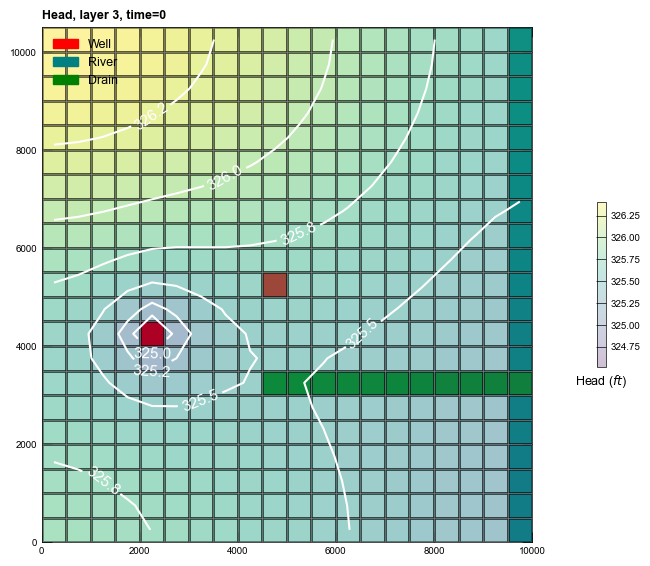

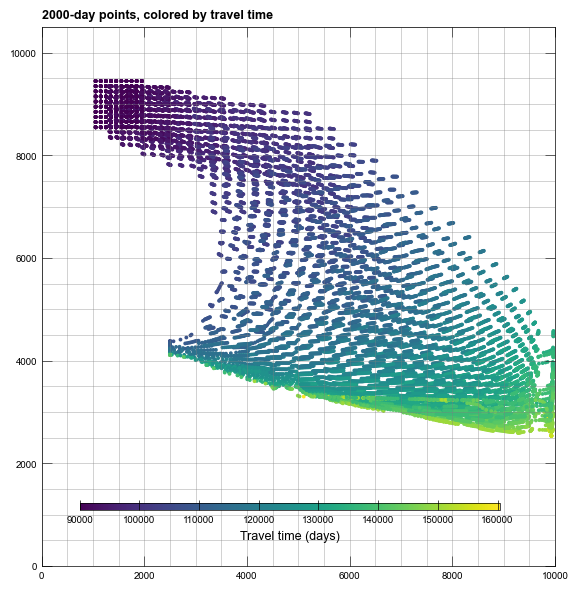

/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


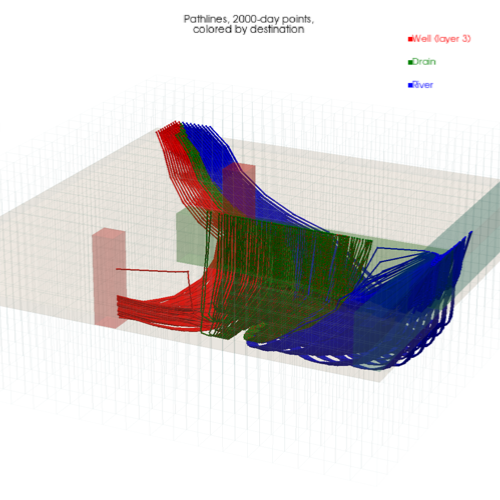

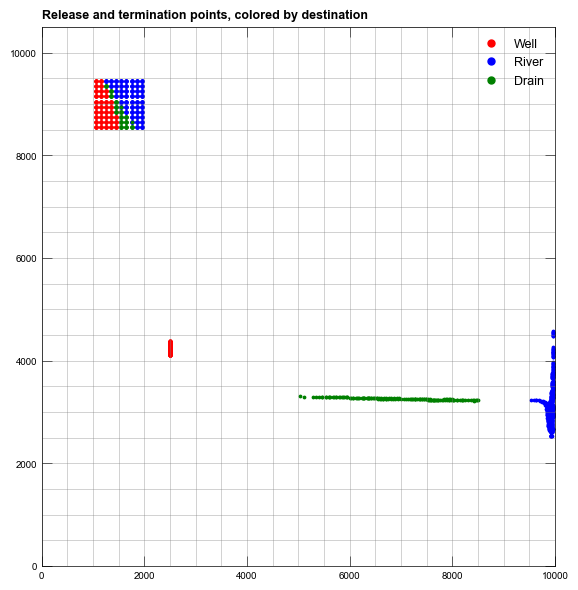

In [8]:
scenario(silent=True)